In [1]:
from __future__ import absolute_import

import csv
import itertools
import logging
import pandas as pd
import pickle
from random import shuffle
import os
import re
import subprocess
import sys
# sys.path.append('/home/jiewen.du/software/imnet/imnet')
import warnings
warnings.filterwarnings('ignore')

import findspark
findspark.init()
import graph_tool.all as gt
import imnet
from imnet.process_strings_cy import get_degrees_cython, generate_matrix_elements_cython
import Levenshtein
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
# from IPython.display import HTML
from pathlib import Path
import pyspark
from pyspark.sql import SparkSession,Row, SQLContext
from pyspark.sql.types import (
    StructField,
    StructType,
    IntegerType,
    ShortType,
    StringType,
    LongType,
)
import seaborn as sns
from scipy.sparse import csr_matrix

In [2]:
# 配置
# export SPARK_HOME="/data/anaconda3/envs/imnet/lib/python3.7/site-packages/pyspark"
# export export PYSPARK_PYTHON="/data/anaconda3/envs/imnet/bin/python"
os.environ['SPARK_HOME'] = "/data/anaconda3/envs/imnet/lib/python3.7/site-packages/pyspark"
os.environ['PYSPARK_PYTHON'] = "/data/anaconda3/envs/imnet/bin/python"

# 解决输出gml文件NetworkXError: 0 is not a string问题
# from sage.misc.interpreter import preparser
# preparser(on=False)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
def distance_matrix(strings, min_ld=1, max_ld=1, sc=None):
    """
    Given the set of strings, return a distance matrix
    
    Inputs
    ------

    strings : list 
        a list of strings to use for the pairwise distance matrix
    min_ld : int, optional
        minimum Levenshtein distance
    max_ld : int, optional
        maximum Levenshtein distance
    sc : pyspark.SparkContext
        a live SparkContext; if none is given, the calculation is done locally

    Returns
    -------

    If `sc` is specified, returns an RDD of (src, dst, distance) tuples. Otherwise a generator 
    of (src, dst, distance) tuples is returned that can be used to construct a sparse matrix or a graph. 
    """

    nstrings = len(strings)
    logger.info("number of strings " + str(nstrings))

    if sc is not None:
        # broadcast the lookup dictionaries
        strings_b = sc.broadcast(strings)

        # create an RDD of indices and balance partitioning
        number_of_partitions = sc.defaultParallelism * 10

        idxs = list(range(nstrings))
        shuffle(idxs)

        idx_rdd = sc.parallelize(idxs, number_of_partitions)

        mat = idx_rdd.mapPartitions(
            lambda x: generate_matrix_elements_cython(
                np.array(list(x), dtype=np.int32), strings_b.value, min_ld, max_ld
            )
        )

    else:
        mat = generate_matrix_elements_cython(
            np.array(range(nstrings), dtype=np.int32), strings, min_ld, max_ld
        )

    return mat

def generate_graph(strings, min_ld=1, max_ld=1, sc=None):
    """
    Generate a distance matrix and produce a graph object 

    Inputs
    ------

    strings : list
        a list of strings to use for the pairwise distance matrix
    min_ld : int, optional
        minimum Levenshtein distance
    max_ld : int, optional
        maximum Levenshtein distance
    sc : pyspark.SparkContext
        a live SparkContext; if none is given, the calculation is done locally

    Returns
    -------
    g : networkx.Graph object with strings used as label names

    """
    mat = distance_matrix(strings, sc=sc, min_ld=min_ld, max_ld=max_ld)

    if sc is not None:
        mat_data = np.array(mat.collect())
    else:
        mat_data = np.array(list(mat))

    if len(mat_data) > 0:
        comb_matrix = csr_matrix(
            (mat_data[:, 2], (mat_data[:, 0], mat_data[:, 1])),
            (len(strings), len(strings)),
        )
        # get the graph from the distance matrix
        g = nx.Graph(comb_matrix)
        string_map = {i: s for i, s in enumerate(strings)}
        nx.relabel_nodes(g, string_map, copy=False)
    else:
        g = nx.Graph()

    return g
def get_degrees_wrapper(*args):
    """Wrapper to enable passing of get_degrees to mapPartitions"""
    res = get_degrees_cython(*args)
    yield res
def iadd(a, b):
    """Helper function for inplace add"""
    a += b
    return a
def generate_degrees(strings, min_ld=1, max_ld=1, sc=None):
    """
    Generate a matrix of degrees for the entire dataset

    Each row of the matrix corresponds to: (string, d1, d2 ... dn), where d1...dn correspond to the 
    number of connections per Levenshtein distance for the given string. 

    Inputs
    ------
    strings : list
        a list of strings to use for the pairwise distance matrix
    
    See `distance_matrix` for a description of the optional keywords. 
    """
    nstrings = len(strings)
    logger.info("number of strings " + str(nstrings))

    idxs = list(range(nstrings))

    if sc is not None:
        strings_b = sc.broadcast(strings)
        shuffle(idxs)
        npartitions = sc.defaultParallelism * 5
        return (
            sc.parallelize(idxs, npartitions)
            .mapPartitions(
                lambda iterator: get_degrees_wrapper(
                    np.fromiter(iterator, dtype=np.int32),
                    strings_b.value,
                    min_ld,
                    max_ld,
                )
            )
            .treeReduce(iadd, 4)
        )
    else:
        return get_degrees_cython(
            np.array(idxs, dtype=np.int32), strings, min_ld, max_ld
        )
def write_output(strings, kind, outfile, min_ld=1, max_ld=1, sc=None):
    """
    Write either graph or csv degrees file to disk

    Inputs
    ------    
    strings : list
        a list of strings to use for the pairwise distance matrix
    kind : string
        one of {'degrees', 'graph'}
    outfile : filename
        output filename
    min_ld : int, optional
        minimum Levenshtein distance
    max_ld : int, optional
        maximum Levenshtein distance
    sc : pyspark.SparkContext
        a live SparkContext; if none is given, the calculation is done locally

    See `imnet.process_strings` for optional keywords
    """

    if kind == "graph":
        if not outfile.endswith(".gml"):
            outfile += ".gml"
        g = generate_graph(strings, min_ld, max_ld, sc)
        nx.write_gml(g, outfile)

    elif kind == "degrees":
        if not outfile.endswith(".degrees.csv"):
            outfile += ".degrees.csv"
        degrees = generate_degrees(strings, min_ld, max_ld, sc)
        df = pd.DataFrame(degrees[:, 1:], columns=range(1, degrees.shape[1]))
        df["string"] = strings
        df[["string"] + range(1, degrees.shape[1])].to_csv(outfile, index=False)

    else:
        raise RuntimeError("'kind' must be one of {'degrees', 'graph'}")

def generate_spark_graph(strings, sc, mat=None, min_ld=1, max_ld=1):
    """
    Make a graph using the Spark graphframes library

    Inputs
    ------

    strings: list
        a list of strings to use for the pairwise distance matrix
    sc : pyspark.SparkContext
        a live SparkContext
    mat : pyspark.RDD, optional
        an RDD representing the distance matrix (returned by `distance_matrix`). If not given, 
        it is generated automatically
    min_ld : int, optional
        minimum Levenshtein distance
    max_ld : int, optional
        maximum Levenshtein distance

    Returns
    -------
    g : graphframes.GraphFrame object with strings as node names

    """
    try:
        import findspark

        findspark.init()
        import graphframes
        from pyspark.sql import Row, SQLContext
        from pyspark.sql.types import (
            StructField,
            StructType,
            IntegerType,
            ShortType,
            StringType,
            LongType,
        )
    except:
        warn("Problem importing pyspark -- are you sure your SPARK_HOME is set?")

    sqc = SQLContext(sc)

    strings_b = sc.broadcast(strings)
    size = len(strings)

    # make the vertex DataFrame
    v_schema = StructType(
        [StructField("id", IntegerType()), StructField("string", StringType())]
    )
    v_rdd = sc.parallelize(range(size)).map(
        lambda x: Row(id=x, string=strings_b.value[x])
    )
    v = sqc.createDataFrame(v_rdd, schema=v_schema)

    # make the edge DataFrame
    if mat is None:
        mat = distance_matrix(strings, min_ld=min_ld, max_ld=max_ld, sc=sc)
    e_schema = StructType(
        [
            StructField("src", IntegerType()),
            StructField("dst", IntegerType()),
            StructField("weight", ShortType()),
        ]
    )
    e = sqc.createDataFrame(mat, schema=e_schema)
    gf = graphframes.GraphFrame(v, e)

    return gf

In [4]:
def beauty_print(datas: list, placeholder_len=3):
    '''
    
    Parmas:
    ------
    datas: list
        First row of the datas is the header
    
    '''
    df = pd.DataFrame(datas)
    col_len = [max(map(lambda x: len(str(x)), df[label]))+placeholder_len for label in df.columns]
    tr = '+'+'+'.join(['-'*i for i in col_len])+'+'
    th = ('|'+'|'.join(['{{:<{}}}'.format(i) for i in col_len])+'|').format(*datas[0])
    print(tr)
    print(th)
    print(tr)
    for row in datas[1:]:
        print(('|'+'|'.join(['{{:<{}}}'.format(i) for i in col_len])+'|').format(*row))
    print(tr)
    
test_data = [['', 'Train', 'Valid'],
   ['Data size', 13361, 1768]]

beauty_print(test_data)

+------------+--------+--------+
|            |Train   |Valid   |
+------------+--------+--------+
|Data size   |13361   |1768    |
+------------+--------+--------+


In [5]:
spark_location = findspark.find()
spark_location

'/data/anaconda3/envs/imnet/lib/python3.7/site-packages/pyspark'

In [6]:
# The entry point to programming Spark with the Dataset and DataFrame API.
spark = SparkSession.builder \
    .master("local[10]") \
    .config("spark.driver.memory", "100G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.executor.memory", "10G") \
    .appName("imnet") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel('ERROR')
sc.addPyFile('/data/anaconda3/envs/imnet/lib/python3.7/site-packages/pyspark/jars/graphframes-0.8.2-spark2.4-s_2.11.jar')

# graphframes模块的加载问题：
# https://stackoverflow.com/questions/39261370/unable-to-run-a-basic-graphframes-example
# https://towardsdatascience.com/install-pyspark-and-use-graphframes-on-macos-and-linux-f2fe62fc3c2d

import graphframes

2022-04-26 07:21:41 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-04-26 07:21:41 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
!pwd

/home/jiewen.du/pySpace


In [8]:
!mkdir /home/jiewen.du/pySpace/checkpoints

mkdir: cannot create directory ‘/home/jiewen.du/pySpace/checkpoints’: File exists


In [9]:
# 教程：https://stackoverflow.com/questions/49159896/how-to-set-checkpiont-dir-pyspark-data-science-experience
# For error: Py4JJavaError: An error occurred while calling o221.run.
# : java.io.IOException: Checkpoint directory is not set. Please set it first using sc.setCheckpointDir(). 
sc.setCheckpointDir('/home/jiewen.du/pySpace/checkpoints')

In [10]:
sc.parallelize(range(sc.defaultParallelism)).collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Load Data

## Dataset

Category | Name | Individual | Source | Label | Protocol
---|---|---|---|---|---
Imnet | ERR1759628 | NP-HEL mouse 1| Bone Marrow | LLPC | IGH 
Imnet | ERR1759629 | NP-HEL mouse 1| Bone Marrow | pre-B cell| IGH
Imnet | ERR1759630 | NP-HEL mouse 1| Spleen | naive B cell| IGH
Imnet | ERR1759631 | NP-HEL mouse 1| Spleen | naive B cell| Ig-Seq
Imnet | ERR1759632 | NP-HEL mouse 1| Spleen | naive B cell| Ig-Seq
---|---|---|---
CM | CM000 | 
CM | CM001 | 
CM | CM002 | 
CM | CM003 | 
CM | CM004 | 
CM | CM005 | 
CM | CM006 | 
CM | CM008 | 

## IMNET 5 mice

In [11]:
ERR_paths = Path('/home/jiewen.du/software/mixcr-3.0.13/reports')
report_fs = sorted(ERR_paths.glob('*clonotypes*IGH*'))

imnet_cdr3s = []
for f in report_fs:
    
    df = pd.read_csv(f, sep='\t')
    df.dropna(axis=0, how='any', subset=['aaSeqCDR3'], inplace=True)
    cdr3s = list(df['aaSeqCDR3'].value_counts().loc[lambda x : x>1].index)
    cdr3s_filterd = list(filter(lambda x: len(x)>4, cdr3s))
    print(f.stem, df.shape[0], len(cdr3s), len(cdr3s), len(cdr3s_filterd))
    imnet_cdr3s.append(cdr3s_filterd)

ERR1759628.clonotypes.IGH 18057 248 248 248
ERR1759629.clonotypes.IGH 216370 9496 9496 9493
ERR1759630.clonotypes.IGH 616100 41187 41187 41187
ERR1759631.clonotypes.IGH 105809 4437 4437 4437
ERR1759632.clonotypes.IGH 108990 4782 4782 4782


# CM000~CM005

In [23]:
root = Path('/data/ab01/to_dujiewen')
train_data_paths = [root/f'CM00{i}_train_clone-pass_germ-pass.tsv' for i in [0,1,2,3]]
valid_data_paths = [root/f'CM00{i}_valid_clone-pass.tsv' for i in [1,2,3]]

CM004_path = root/'CM004_all_clone-pass.tsv'
CM005_path = root/'CM005_all_clone-pass.tsv'
df4 = pd.read_csv(root/'CM004_all_clone-pass.tsv', sep='\t')
df4_valid = df4.loc[df4['mice_index'].isin(['VMM_1','VMM_2']),:]
df4_train = df4.loc[~df4.index.isin(df4_valid.index),:]

df5 = pd.read_csv(root/'CM005_all_clone-pass.tsv', sep='\t')
df5_valid = df5.loc[df5['mice_index']=='VMM_2',:]
df5_train = df5.loc[~df5.index.isin(df5_valid.index),:]

train_dfs = [pd.read_csv(f,sep='\t') for f in train_data_paths]
valid_dfs = [pd.read_csv(f,sep='\t') for f in valid_data_paths]
train_dfs.extend([df4_train, df5_train])
valid_dfs.extend([df4_valid, df5_valid])

CM_cdr3s = [list(df['cdr3_aa'].value_counts().loc[lambda x : x>1].index) for df in train_dfs]
CM_cdr3s.extend([list(df['cdr3_aa'].value_counts().loc[lambda x : x>1].index) for df in valid_dfs])
CM_cdr3s_over = [list(filter(lambda x: len(x)>=4, cdr3s)) for cdr3s in CM_cdr3s]

In [13]:
beauty_print([
    ['Sequences', *[df.shape[0] for df in train_dfs], *[df.shape[0] for df in valid_dfs]],
    ['CDR3 count > 1', *[len(x) for x in CM_cdr3s]],
    ['CDR3 length >= 4 a.a.', *[len(x) for x in CM_cdr3s_over]]
])

+-----------------------+-------+--------+-------+--------+--------+-------+-------+-------+-------+------+------+
|Sequences              |1770   |13361   |9802   |17018   |26801   |1803   |1768   |2184   |1129   |880   |160   |
+-----------------------+-------+--------+-------+--------+--------+-------+-------+-------+-------+------+------+
|CDR3 count > 1         |213    |1460    |1119   |1468    |1618    |195    |140    |322    |147    |108   |5     |
|CDR3 length > 4 a.a.   |213    |1460    |1119   |1467    |1618    |195    |140    |322    |147    |108   |5     |
+-----------------------+-------+--------+-------+--------+--------+-------+-------+-------+-------+------+------+


In [33]:
# 12787 cm06_all.tsv
# 12785 cm06_all_clone-pass.tsv

# 14569 cm08_all.tsv
# 14562 cm08_all_clone-pass.tsv

In [27]:
CM_cdr3s_train = [list(df['cdr3_aa'].unique()) for df in train_dfs[1:]]
CM_cdr3s_valid = [list(df['cdr3_aa'].unique()) for df in valid_dfs]

In [47]:
cm0_cd3rs = list(train_dfs[0]['cdr3_aa'].unique())
df_cm00.dropna(subset=['cdr3_aa'], how='any', axis=0, inplace=True)
cm00_cd3rs = list(df_cm00['cdr3_aa'].unique())

In [49]:
len(cm00_cd3rs)

3650

In [75]:
dist_mats = []
dist_mats.append(list(distance_matrix(cm0_cd3rs, 1, 12, None)))
dist_mats.append(list(distance_matrix(cm00_cd3rs, 1, 12, None)))
for cdr3 in CM_cdr3s_train:
    dist_mats.append(list(distance_matrix(cdr3, 1, 12, None)))
for cdr3 in CM_cdr3s_valid:
    dist_mats.append(list(distance_matrix(cdr3, 1, 12, None)))

INFO:__main__:number of strings 1328
INFO:__main__:number of strings 3650
INFO:__main__:number of strings 3775
INFO:__main__:number of strings 2970
INFO:__main__:number of strings 4049
INFO:__main__:number of strings 3723
INFO:__main__:number of strings 470
INFO:__main__:number of strings 368
INFO:__main__:number of strings 845
INFO:__main__:number of strings 511
INFO:__main__:number of strings 222
INFO:__main__:number of strings 14


In [60]:
degree_mats = []
degree_mats.append(generate_degrees(cm0_cd3rs, 1, 12, None))
degree_mats.append(generate_degrees(cm00_cd3rs, 1, 12, None))
for cdr3 in CM_cdr3s_train:
    degree_mats.append(generate_degrees(cdr3, 1, 12, None))
for cdr3 in CM_cdr3s_valid:
    degree_mats.append(generate_degrees(cdr3, 1, 12, None))

INFO:__main__:number of strings 1328
INFO:__main__:number of strings 3650
INFO:__main__:number of strings 3775
INFO:__main__:number of strings 2970
INFO:__main__:number of strings 4049
INFO:__main__:number of strings 3723
INFO:__main__:number of strings 470
INFO:__main__:number of strings 368
INFO:__main__:number of strings 845
INFO:__main__:number of strings 511
INFO:__main__:number of strings 222
INFO:__main__:number of strings 14


In [88]:
# sources = ['CM0']*12+['CM00']*12
# sources.extend([f'CM00{i}_train' for i in range(1,6) for x in range(0,12)])
# sources.extend([f'CM00{i}_valid' for i in range(1,6) for x in range(0,12)])
# LDs = [i for x in range(0,12) for i in range(1,13)]
# LD_cnt = [degrees[:, i].sum()/2  for i in range(1,13)]
LD_values = []
for dists in dist_mats:
    LD_values.append([ld[2] for ld in dists])

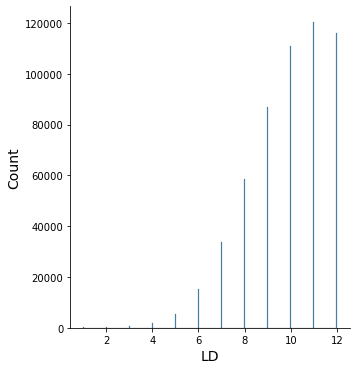

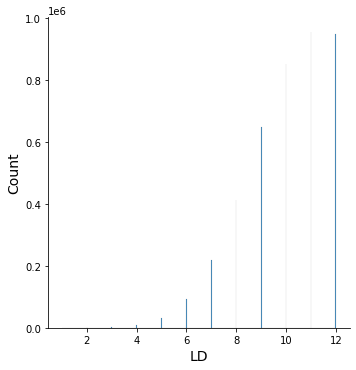

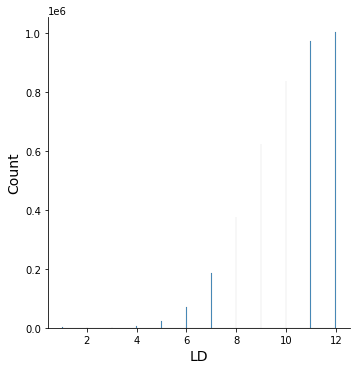

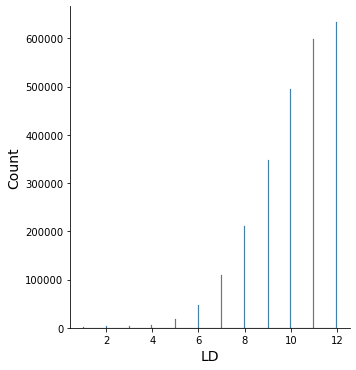

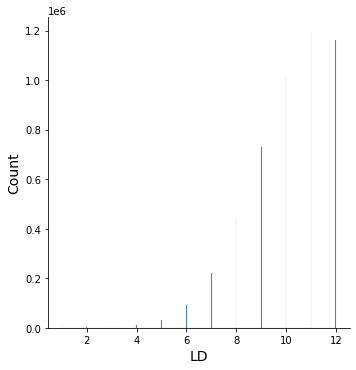

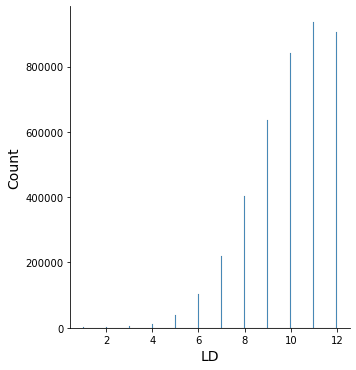

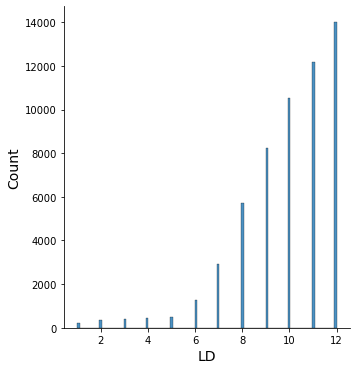

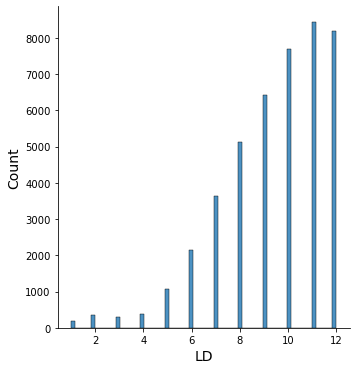

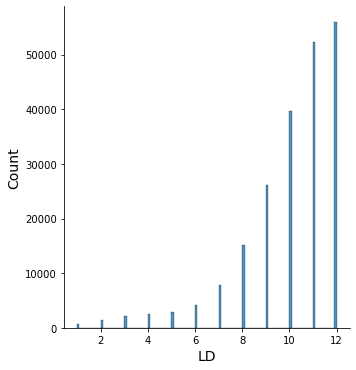

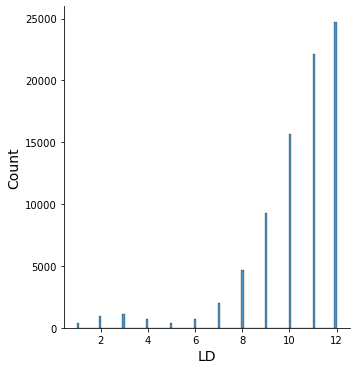

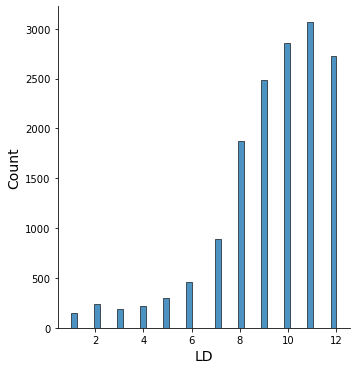

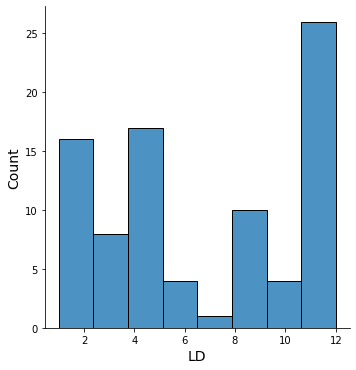

In [95]:
# plt.figure(figsize=(10, 10))

plot_df = pd.DataFrame({"Source": sources, "LD": LDs, "Count": LD_cnt})

for lds in LD_values:
    ax = sns.displot(
        data=lds,
        kind='hist',
        palette='dark',
        alpha=0.8
    )
    # plt.xticks(rotation=45)
    # plt.yticks(rotation=45)
    plt.xlabel("LD", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    # plt.legend(title='Feature', fontsize='large', title_fontsize='large', loc=0)
    plt.show()



# plt.legend(title='Feature', fontsize='large', title_fontsize='large', loc=0)

# plt.savefig("./plot/network_size.png", format='png', transparent=True)

# Second CM00, 8 mice

In [12]:
df_cm00 = pd.read_csv('/data/nfs/cm00_all.tsv', sep='\t')
print(df_cm00.shape)

(15494, 107)


In [13]:
df_cm00.head(3)

,stim,sequence_id,sequence,locus,stop_codon,vj_in_frame,v_frameshift,productive,rev_comp,complete_vdj,...,consensus_count,umi_count,v_call_10x,d_call_10x,j_call_10x,junction_10x,junction_10x_aa,barcode,celltype,mice_index
0,TSM_1,GTATCTTTCAATACCG-1.TSM_1,AGTGCTTTCTGAGAGTCATGGACCTCCTGCACAAGAACATGAAACA...,IGH,False,True,False,True,False,True,...,45772,13243,hsa-IGHV4-34,NaN,hsa-IGHJ6,TGTGCGAGAGGTCTCGACTACAGTAACTACGGTTATTACTTCTACT...,CARGLDYSNYGYYFYYGMDVW,GTATCTTTCAATACCG-1.TSM_1,Plasma cells,TSM_1
1,TSM_3,TCTTTCCGTCTCTTTA-1.TSM_3,ACCATCACACAACAGCCACATCCCTCCCCTACAGAAGCCCCCAGAG...,IGH,False,True,False,True,False,False,...,49712,13218,hsa-IGHV1-24,NaN,hsa-IGHJ6,TGTGCAACAACACGGGGATGGTTCGGGGAGCCCCGCAACTACCACG...,CATTRGWFGEPRNYHGLDVW,TCTTTCCGTCTCTTTA-1.TSM_3,Plasma cells,TSM_3
2,TSM_1,AGCTTGACAGGAATCG-1.TSM_1,GGAGTCTCCCTCACTGCCCAGCTGGGATCTCAGGGCTTCATTTTCT...,IGH,False,True,False,True,False,True,...,55406,13215,hsa-IGHV5-51,hsa-IGHD1-7,hsa-IGHJ6,TGTACGACGTATAACTGGAACTACGACTACTACTACGGTATGGACG...,CTTYNWNYDYYYGMDVW,AGCTTGACAGGAATCG-1.TSM_1,Plasma cells,TSM_1


In [14]:
df_cm0 = pd.read_csv('/home/jiewen.du/data/processed_data/CM000_train_clone-pass_germ-pass.tsv', sep='\t')
print(df_cm0.shape)

(1770, 116)


In [22]:
df_cm00.loc[:, ['celltype', 'mice_index']].value_counts().sort(index='celltype')

AttributeError: 'Series' object has no attribute 'sort'

In [26]:
df=pd.read_csv('imnet_params/all_graph_params.tsv', sep='\t')
df.head(3)

,source,nodes,edges,component_cnt,largest_component_size,perc_giant_component,diameter,assortativity,density,X1,...,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
0,CM000_train,213,15423,1,213,1.0,3,0.077040,0.683099,0.206573,...,0.173709,0.323944,0.474178,0.647887,0.816901,0.910798,0.971831,0.990610,1.0,1.0
1,CM001_train,1460,635529,1,1460,1.0,3,0.102550,0.596702,0.480822,...,0.373288,0.494521,0.669178,0.839726,0.932877,0.978082,0.993836,0.996575,1.0,1.0
2,CM002_train,1119,343747,1,1119,1.0,4,0.017152,0.549537,0.507596,...,0.461126,0.535299,0.661305,0.786416,0.891868,0.960679,0.986595,0.994638,1.0,1.0


In [17]:
df_cm0.mice_index.value_counts()

TSM_12    765
TSM_11    657
TSM_10    348
Name: mice_index, dtype: int64

In [27]:
df['sequence_cnt'] = [df.shape[0] for df in train_dfs]+[df.shape[0] for df in valid_dfs]

In [29]:
df.loc[:, ['source', 'sequence_cnt', 'nodes']]

,source,sequence_cnt,nodes
0,CM000_train,1770,213
1,CM001_train,13361,1460
2,CM002_train,9802,1119
3,CM003_train,17018,1467
4,CM004_train,26801,1618
5,CM005_train,1803,195
6,CM001_valid,1768,140
7,CM002_valid,2184,322
8,CM003_valid,1129,147
9,CM004_valid,880,108


In [28]:
df.to_csv('imnet_params/all_graph_params.tsv', index=None, sep='\t')

In [23]:
print('valids: ', )

valids:  [1768, 2184, 1129, 880, 160]


+--------------+----------+----------+
|              |Train     |Valid     |
+--------------+----------+----------+
|Data size     |13361     |1768      |
+--------------+----------+----------+


# Creating the distance matrix

In [6]:
MAX_LD = 12

In [8]:
# mats = []
# for cdr3s in cdr3_over:
#     mat_arr = np.array(list(imnet.process_strings.distance_matrix(cdr3s, min_ld=1, max_ld=MAX_LD)))
#     mat = csr_matrix((mat_arr[:,2], (mat_arr[:,0], mat_arr[:,1])), (len(cdr3s), len(cdr3s)))
#     mats.append(mat)

INFO:imnet.process_strings:number of strings 213
INFO:imnet.process_strings:number of strings 1460
INFO:imnet.process_strings:number of strings 1119
INFO:imnet.process_strings:number of strings 1467
INFO:imnet.process_strings:number of strings 1618
INFO:imnet.process_strings:number of strings 195
INFO:imnet.process_strings:number of strings 140
INFO:imnet.process_strings:number of strings 322
INFO:imnet.process_strings:number of strings 147
INFO:imnet.process_strings:number of strings 108
INFO:imnet.process_strings:number of strings 5


In [56]:
# %%time
# mat_spark_arr_cdr3_CM001_train = np.array(distance_matrix(cdr3_CM001_train, min_ld=1, max_ld=MAX_LD, sc=sc).collect())
# mat_spark_cdr3_CM001_train = csr_matrix((mat_spark_arr_cdr3_CM001_train[:,2], (mat_spark_arr_cdr3_CM001_train[:,0], mat_spark_arr_cdr3_CM001_train[:,1])), (len(cdr3_CM001_train), len(cdr3_CM001_train)))

INFO:__main__:number of strings 3775
[Stage 11:=========================================>            (76 + 10) / 100]

CPU times: user 36.7 ms, sys: 35.3 ms, total: 72 ms
Wall time: 1.07 s


In [57]:
# %%time
# mat_spark_arr_cdr3_CM001_valid = np.array(distance_matrix(cdr3_CM001_valid, min_ld=1, max_ld=MAX_LD, sc=sc).collect())
# mat_spark_cdr3_CM001_valid = csr_matrix((mat_spark_arr_cdr3_CM001_valid[:,2], (mat_spark_arr_cdr3_CM001_valid[:,0], mat_spark_arr_cdr3_CM001_valid[:,1])), (len(cdr3_CM001_valid), len(cdr3_CM001_valid)))

INFO:__main__:number of strings 368


CPU times: user 70.6 ms, sys: 13.6 ms, total: 84.2 ms
Wall time: 511 ms


## 实验设计
1. across species (区分物种)
2. across key stages of B-cell development (区分不同的B cell)
3. before (pBC, nBC) and after antigen-driven clonal selection and expansion (PC, memory B-cells)
4. differences in the complexity of the protein antigen (区分不同的免疫状态)
5. across a scale of different repertoire sizes (102–106 of unique CDR3 clones)

## Global pattern
1. remarkable cross-mouse consistency in clonal interconnectedness (similarity of antibody sequences) within each B-cell stage

# Generate a graph from the distance matrix

报错：ERROR TaskSetManager:70 - Total size of serialized results of 46 tasks (1043.6 MB) is bigger than spark.driver.maxResultSize (1024.0 MB)</br>
解决：http://bourneli.github.io/scala/spark/2016/09/21/spark-driver-maxResultSize-puzzle.html

In [96]:
cm00_cdr3s = list(df_cm00['cdr3_aa'].value_counts().loc[lambda x : x>1].index)

In [97]:
cm00_cdr3s_over = list(filter(lambda x: len(x)>=4, cm00_cdr3s))

In [98]:
len(cm00_cdr3s_over)

871

In [99]:
cm00_g = generate_graph(cm00_cdr3s_over, min_ld=1, max_ld=12, sc=None)

INFO:__main__:number of strings 871


In [102]:
nx.write_gml(cm00_g, 'gml/cm00.gml', stringizer=str)

In [14]:
MAX_LD = 12

In [17]:
imnet_gs = []
for cdr3s in imnet_cdr3s:
    if len(cdr3s)>2000:
        # Generate distributed graph
        # g = generate_graph(cdr3s, min_ld=1, max_ld=MAX_LD, sc=sc)
        g = generate_spark_graph(cdr3s, sc, max_ld=MAX_LD).cache()
    else:
        g = generate_graph(cdr3s, min_ld=1, max_ld=MAX_LD, sc=None)
    imnet_gs.append(g)

INFO:__main__:number of strings 248
INFO:__main__:number of strings 9493
INFO:__main__:number of strings 41187
INFO:__main__:number of strings 4437
INFO:__main__:number of strings 4782


In [18]:
# Convert Grapframe to Networkx and don't keep Grapframe
def graphframe_to_netwrokx(g_rdd):
    '''
    
    Params
    ------
    g_rdd: graphframes.GraphFrame object
    
    Returns
    ------
    nx_g: networkx.Graph object with strings used as label names
    
    '''
    nodes_pdf = g_rdd.vertices.toPandas()
    edges_pdf = g_rdd.edges.toPandas()
    print(f'Nodes: {nodes_pdf.shape[0]} | Edges: {edges_pdf.shape[0]}')
    nx_g = nx.from_pandas_edgelist(edges_pdf, 'src', 'dst', edge_attr='weight')
    # string_map = {i: s for i, s in nodes_pdf.itertuples(False)}
    # nx.relabel_nodes(nx_g, string_map, copy=False)
    print(f'******Graph converted done!******')
    return nx_g

imnet_gs[1] = graphframe_to_netwrokx(imnet_gs[1])
imnet_gs[3] = graphframe_to_netwrokx(imnet_gs[3])
imnet_gs[4] = graphframe_to_netwrokx(imnet_gs[4])

Nodes: 9493 | Edges: 43706427
******Graph converted done!******


Nodes: 4437 | Edges: 9775536
******Graph converted done!******


Nodes: 4782 | Edges: 11354750
******Graph converted done!******


In [20]:
nx.write_gml(imnet_gs[0], 'gml/ERR1759628.gml', stringizer=str)

In [21]:
nx.write_gml(imnet_gs[1], 'gml/ERR1759629.gml', stringizer=str)

In [22]:
nx.write_gml(imnet_gs[3], 'gml/ERR1759631.gml', stringizer=str)

In [23]:
nx.write_gml(imnet_gs[4], 'gml/ERR1759632.gml', stringizer=str)

In [30]:
CM_gs = []
for cdr3s in CM_cdr3s_over:
    g = generate_graph(cdr3s, min_ld=1, max_ld=MAX_LD, sc=None)
    CM_gs.append(g)
# edge data: ('ATEYNWNYGDWFDP', 'ARGADY', {'weight': 11})

INFO:__main__:number of strings 213
INFO:__main__:number of strings 1460
INFO:__main__:number of strings 1119
INFO:__main__:number of strings 1467
INFO:__main__:number of strings 1618
INFO:__main__:number of strings 195
INFO:__main__:number of strings 140
INFO:__main__:number of strings 322
INFO:__main__:number of strings 147
INFO:__main__:number of strings 108
INFO:__main__:number of strings 5


In [173]:
# 持久化network
# Note: networkx输出gml文件时，除过node id和edge id为int外，attribute均为str,所以需要指定stringizer=str
# > https://ask.sagemath.org/question/59433/how-to-save-a-networkx-graph-so-it-can-be-read-in-python/
gml_path = Path('gml')
# if not gml_path.exists():
#     gml_path.mkdir(mode=511, parents=True)
for i in range(0, 11):
    if i<6:
        nx.write_gml(gs[i], gml_path/f'CM00{i}_train.gml', stringizer=str)
        print(f'CM00{i}_train.gml is writed.')
    else:
        nx.write_gml(gs[i], gml_path/f'CM00{i-5}_valid.gml', stringizer=str)
        print(f'CM00{i-5}_valid.gml is writed.')

CM000_train.gml is writed.
CM001_train.gml is writed.
CM002_train.gml is writed.
CM003_train.gml is writed.
CM004_train.gml is writed.
CM005_train.gml is writed.
CM001_valid.gml is writed.
CM002_valid.gml is writed.
CM003_valid.gml is writed.
CM004_valid.gml is writed.
CM005_valid.gml is writed.


# Network properties

## A. Network size of antibody repertoires

In [10]:
index_labels = [f'CM00{i}_train' for i in range(6)]
index_labels.extend([f'CM00{i}_valid' for i in range(1, 6)])
print(index_labels)

['CM000_train', 'CM001_train', 'CM002_train', 'CM003_train', 'CM004_train', 'CM005_train', 'CM001_valid', 'CM002_valid', 'CM003_valid', 'CM004_valid', 'CM005_valid']


In [ ]:
# clique
# clique_0 = nx.make_max_clique_graph(gs[0])
# clique_0.order()

In [100]:
# Global parameters
cols_A = ['nodes', 'edges', 'component_cnt', 'largest_component_size', 'perc_giant_component']

def cmp_global_params(graph):
    nodes = graph.order()
    edges = graph.size()
    component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
    component_cnt = len(component_sizes)
    # average_component_size = sum(component_sizes)/component_cnt
    largest_component_size = component_sizes[0]
    perc_giant_component = round(largest_component_size/nodes ,4)

    return [nodes, edges, component_cnt, largest_component_size, perc_giant_component]

In [101]:
print(cmp_global_params(cm00_g))

[871, 242340, 1, 871, 1.0]


In [29]:
# for IMNET
imnet_network_sizes = []
for i in [0,1,3,4]:
    imnet_network_sizes.append(cmp_global_params(imnet_gs[i]))

network_size_data = [cols_A]+imnet_network_sizes
beauty_print(network_size_data)

+--------+-----------+----------------+-------------------------+-----------------------+
|nodes   |edges      |component_cnt   |largest_component_size   |perc_giant_component   |
+--------+-----------+----------------+-------------------------+-----------------------+
|248     |29338      |1               |248                      |1.0                    |
|9493    |43706427   |1               |9493                     |1.0                    |
|4437    |9775536    |1               |4437                     |1.0                    |
|4782    |11354750   |1               |4782                     |1.0                    |
+--------+-----------+----------------+-------------------------+-----------------------+


In [38]:
imnet_gs[2].vertices.count()

41187

In [39]:
imnet_gs[2].edges.count()

836523361

In [40]:
comp_rdd = imnet_gs[2].connectedComponents()

In [41]:
gb = comp_rdd.groupBy('component')
gb.count().sort('count', ascending=False).show()

+---------+-----+
|component|count|
+---------+-----+
|        0|41187|
+---------+-----+



In [ ]:
for i in [0,1,3,4]:
    print(nx.diameter(imnet_gs[i]))

2


In [15]:
# for CM
network_sizes = []
for g in CM_gs:
    network_sizes.append(cmp_global_params(g))

network_size_data = [cols_A]+network_sizes
beauty_print(network_size_data)

+----------+-----------+------------------+---------------------------+-------------------------+
|nodes     |edges      |component_cnt     |largest_component_size     |perc_giant_component     |
+----------+-----------+------------------+---------------------------+-------------------------+
|213       |15423      |1                 |213                        |1.0                      |
|1460      |635529     |1                 |1460                       |1.0                      |
|1119      |343747     |1                 |1119                       |1.0                      |
|1467      |670497     |3                 |1465                       |0.9986                   |
|1618      |806746     |2                 |1611                       |0.9957                   |
|195       |10845      |2                 |194                        |0.9949                   |
|140       |7250       |1                 |140                        |1.0                      |
|322       |30500   

In [18]:
df_network_size = pd.DataFrame(network_sizes, columns=cols_A)
df_network_size['source'] = index_labels
df_network_size = df_network_size.loc[:, ['source', *df_network_size.columns[:-1]]]
df_network_size

,source,nodes,edges,component_cnt,largest_component_size,perc_giant_component
0,CM000_train,213,15423,1,213,1.0000
1,CM001_train,1460,635529,1,1460,1.0000
2,CM002_train,1119,343747,1,1119,1.0000
3,CM003_train,1467,670497,3,1465,0.9986
4,CM004_train,1618,806746,2,1611,0.9957
5,CM005_train,195,10845,2,194,0.9949
6,CM001_valid,140,7250,1,140,1.0000
7,CM002_valid,322,30500,1,322,1.0000
8,CM003_valid,147,7324,1,147,1.0000
9,CM004_valid,108,3911,2,106,0.9815


In [19]:
df_network_size.to_csv('imnet_params/network_size.tsv', index=None, sep='\t')

In [101]:
# 计算degree_centrality
fw = open('imnet_params/clonal_params.pkl','rb')
clonal_params = pickle.load(fw)
fw.close()

dcs = dict()
for g,source in zip(gs, index_labels):
    node_map = {node:node_id for node_id, node in enumerate(g.nodes)}
    dc = nx.degree_centrality(g) # Return: nodes dictionary
    clonal_params[source]['degree_centrality'] = [dc[node] for node, node_id in node_map.items()] 

fw2 = open('imnet_params/clonal_params.pkl','wb')
pickle.dump(data, fw2)
fw2.close()

# Generate degrees

In [31]:
# for IMNET
imnet_degrees = []
for cdr3s in imnet_cdr3s:
    degree = generate_degrees(cdr3s, min_ld=1, max_ld=MAX_LD, sc=sc)
    imnet_degrees.append(np.array(degree))

INFO:__main__:number of strings 248
INFO:__main__:number of strings 9493                                            
INFO:__main__:number of strings 41187                                           
INFO:__main__:number of strings 4437                                            
INFO:__main__:number of strings 4782                                            


In [37]:
fw = open('imnet_params/degree_statics_imnet_20220424.pkl','wb')
degree_data = dict()
for source, degree in zip(['ERR1759628', 'ERR1759629', 'ERR1759630', 'ERR1759631', 'ERR1759632'], imnet_degrees):
    degree_data[source] = degree

pickle.dump(degree_data, fw)
fw.close()

In [36]:
imnet_degrees[3].shape

(4437, 13)

In [31]:
# for CM
CM_degrees = []
for cdr3s in CM_cdr3s_over:
    degree = generate_degrees(cdr3s, min_ld=1, max_ld=MAX_LD, sc=None)
    CM_degrees.append(np.array(degree))

INFO:__main__:number of strings 213
INFO:__main__:number of strings 1460
INFO:__main__:number of strings 1119
INFO:__main__:number of strings 1467
INFO:__main__:number of strings 1618
INFO:__main__:number of strings 195
INFO:__main__:number of strings 140
INFO:__main__:number of strings 322
INFO:__main__:number of strings 147
INFO:__main__:number of strings 108
INFO:__main__:number of strings 5


In [ ]:
fw = open('imnet_params/degree_statics.pkl','wb')
degree_data = dict()
for source, degree in zip(index_labels, CM_degrees):
    degree_data[source] = degree

pickle.dump(degree_data, fw)
fw.close()

In [39]:
# average_degrees = []
# for g in gs:
#     degree_g = g.degree()
#     average_degree = sum([deg for cdr3, deg in degree_g])/len(degree_g)
#     average_degrees.append(average_degree)

# beauty_print([('Source', 'Average_degree')]+list(zip(index_labels,average_degrees)))

+----------------+-----------------------+
|Source          |Average_degree         |
+----------------+-----------------------+
|CM000_train     |144.81690140845072     |
|CM001_train     |870.5876712328767      |
|CM002_train     |614.3824843610366      |
|CM003_train     |914.1063394683026      |
|CM004_train     |997.2138442521632      |
|CM005_train     |111.23076923076923     |
|CM001_valid     |103.57142857142857     |
|CM002_valid     |189.44099378881987     |
|CM003_valid     |99.64625850340136      |
|CM004_valid     |72.42592592592592      |
|CM005_valid     |4.0                    |
+----------------+-----------------------+


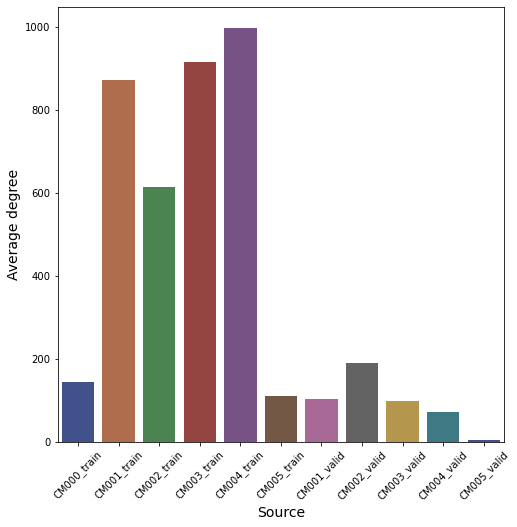

In [46]:
plt.figure(figsize=(8, 8))
plot_df = pd.DataFrame({"Source": index_labels, "Average_degree": average_degrees})

ax = sns.barplot(
    data=plot_df,
    x="Source",
    y="Average_degree",
    ci="sd",
    palette="dark",
    alpha=0.8
)

plt.xticks(rotation=45)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average degree", fontsize=14)

# plt.legend(title='Feature', fontsize='large', title_fontsize='large', loc=0)

plt.savefig("./plot/averafe_degree.png", format='png', transparent=True)
plt.show()

In [170]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

# mcolors.BASE_COLORS
# mcolors.CSS4_COLORS
# mcolors.TABLEAU_COLORS

colors = list(mcolors.TABLEAU_COLORS.values())
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [187]:
def gen_index(start=0, end=5):
    seq=[0,0]
    for a,b in zip(range(start+1,end+1), range(end+1,end*2+1)):
        seq.append(a)
        seq.append(b)
    return seq
gen_index()

[0, 0, 1, 6, 2, 7, 3, 8, 4, 9, 5, 10]

In [188]:
for i in gen_index():
    print(index_labels[i])

CM000_train
CM000_train
CM001_train
CM001_valid
CM002_train
CM002_valid
CM003_train
CM003_valid
CM004_train
CM004_valid
CM005_train
CM005_valid


In [262]:
index_labels

['CM000_train',
 'CM001_train',
 'CM002_train',
 'CM003_train',
 'CM004_train',
 'CM005_train',
 'CM001_valid',
 'CM002_valid',
 'CM003_valid',
 'CM004_valid',
 'CM005_valid']

In [249]:
LD_size = []
for label, dataset_idx in zip(index_labels, range(0,11)):
    LD_size.append([degrees[dataset_idx][degrees[dataset_idx][:,LD]>0,LD].shape[0] for LD in range(1,13)])

beauty_print([[f'LD{x}' for x in range(1,13)], *LD_size], placeholder_len=3)

+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+
|LD1   |LD2   |LD3   |LD4   |LD5    |LD6    |LD7    |LD8    |LD9    |LD10   |LD11   |LD12   |
+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+
|44    |33    |37    |69    |101    |138    |174    |194    |207    |211    |213    |213    |
|702   |605   |545   |722   |977    |1226   |1362   |1428   |1451   |1455   |1460   |1460   |
|568   |545   |516   |599   |740    |880    |998    |1075   |1104   |1113   |1119   |1119   |
|731   |725   |750   |878   |1087   |1241   |1339   |1416   |1450   |1461   |1463   |1465   |
|537   |562   |654   |963   |1208   |1397   |1513   |1568   |1597   |1607   |1609   |1611   |
|83    |78    |64    |67    |66     |100    |142    |157    |184    |190    |194    |194    |
|73    |66    |60    |67    |85     |107    |119    |130    |131    |139    |140    |140    |
|205   |190   |182   |173   |190    |218    |266    |294    

In [218]:
LDs[1]

array([6, 3, 2, 5, 1, 3, 1, 2, 1, 3, 1, 1, 3, 6, 1, 1, 1, 1, 1, 2, 4, 6,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 3], dtype=int32)

# Degree distribution fit

#### Fitter函数使用

1. f.summary() #返回排序好的分布拟合质量（拟合效果从好到坏）,并绘制数据分布和Nbest分布
2. f.df_errors #返回这些分布的拟合质量（均方根误差的和）
3. f.fitted_param #返回拟合分布的参数
4. f.fitted_pdf #使用最适合数据分布的分布参数生成的概率密度
5. f.get_best(method='sumsquare_error') #返回最佳拟合分布及其参数
6. f.hist() #绘制组数=bins的标准化直方图
7. f.plot_pdf(names=None, Nbest=3, lw=2) #绘制分布的概率密度函数

In [ ]:
data_idx=6
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[6]}')
f.summary()  # 输出拟合结果

INFO:root:Fitted cosine distribution with error=0.19676192544577017)
INFO:root:Fitted anglit distribution with error=0.19780785354029404)
INFO:root:Fitted expon distribution with error=0.1622401814670485)
INFO:root:Fitted arcsine distribution with error=0.18447291816031464)
INFO:root:Fitted cauchy distribution with error=0.15749831826948466)
INFO:root:Fitted dgamma distribution with error=0.1846068815627919)
INFO:root:Fitted dweibull distribution with error=0.1888739526620184)
INFO:root:Fitted fatiguelife distribution with error=0.13546785852143997)
INFO:root:Fitted gumbel_l distribution with error=0.19964708175827628)
INFO:root:Fitted gumbel_r distribution with error=0.185618783902036)
INFO:root:Fitted bradford distribution with error=0.18308641005706405)
INFO:root:Fitted chi distribution with error=0.14303633854812095)
INFO:root:Fitted hypsecant distribution with error=0.18941752347815993)
INFO:root:Fitted gilbrat distribution with error=0.15448539174362103)
INFO:root:Fitted chi2 dis

Fitted cumulative degree distribution on LD1-layer of CM001_valid


,sumsquare_error,aic,bic,kl_div
levy,0.130610,1106.706187,-33.700410,inf
invweibull,0.130620,1097.441738,-31.502517,inf
genextreme,0.130620,1097.441049,-31.502515,inf
norminvgauss,0.131300,1079.323934,-29.258556,inf
invgauss,0.131313,1077.167109,-31.454907,inf


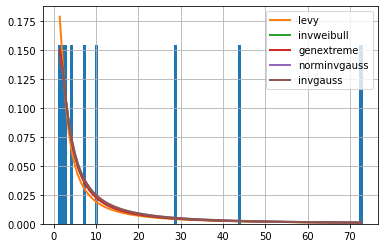

In [259]:
data_idx=6
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[6]}')
f.summary()  # 输出拟合结果

INFO:root:Fitted anglit distribution with error=0.0426196528212956)
INFO:root:Fitted cosine distribution with error=0.04253309489510805)
INFO:root:Fitted expon distribution with error=0.03862077218084269)
INFO:root:Fitted cauchy distribution with error=0.039547105638967815)
INFO:root:Fitted arcsine distribution with error=0.04024666077336063)
INFO:root:Fitted alpha distribution with error=0.03353226008455089)
INFO:root:Fitted gumbel_l distribution with error=0.04289465456936762)
INFO:root:Fitted bradford distribution with error=0.04028724478351453)
INFO:root:Fitted gumbel_r distribution with error=0.04136687169346594)
INFO:root:Fitted laplace distribution with error=0.041066902287622)
INFO:root:Fitted argus distribution with error=0.04296124152901753)
INFO:root:Fitted beta distribution with error=0.040428146502682685)
INFO:root:Fitted burr12 distribution with error=0.027085192708216767)
INFO:root:Fitted dgamma distribution with error=0.04150263936470806)
INFO:root:Fitted dweibull distr

Fitted cumulative degree distribution on LD1-layer of CM001_valid


,sumsquare_error,aic,bic,kl_div
chi2,0.026454,1592.342944,-33.210158,inf
invgamma,0.026589,1374.261773,-33.174357,inf
t,0.026642,1531.407496,-33.160611,inf
pareto,0.026709,1364.987128,-33.142879,inf
burr12,0.027085,1360.506597,-31.099107,inf


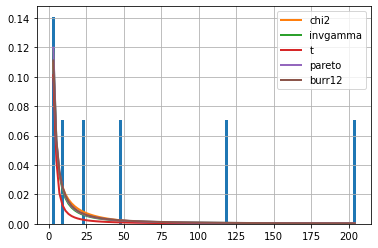

In [260]:
data_idx=7
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

INFO:root:Fitted anglit distribution with error=0.16724517876181255)
INFO:root:Fitted expon distribution with error=0.14355654332434317)
INFO:root:Fitted cosine distribution with error=0.17588212878450551)
INFO:root:Fitted alpha distribution with error=0.13359173091233464)
INFO:root:Fitted cauchy distribution with error=0.14906448845020573)
INFO:root:Fitted arcsine distribution with error=0.16517792609976203)
INFO:root:Fitted fatiguelife distribution with error=0.12807101173520977)
INFO:root:Fitted gumbel_l distribution with error=0.17848664675236026)
INFO:root:Fitted gumbel_r distribution with error=0.16203698846670134)
INFO:root:Fitted dgamma distribution with error=0.16159974495385207)
INFO:root:Fitted foldcauchy distribution with error=0.13160007319012093)
INFO:root:Fitted hypsecant distribution with error=0.16487216278979774)
INFO:root:Fitted gilbrat distribution with error=0.13830128951509224)
INFO:root:Fitted invgauss distribution with error=0.11959051718506919)
INFO:root:Fitted

Fitted cumulative degree distribution on LD1-layer of CM003_valid


,sumsquare_error,aic,bic,kl_div
invweibull,0.119003,1136.152241,-27.426075,inf
genextreme,0.119003,1136.154048,-27.426070,inf
nct,0.119074,1158.136655,-25.341832,inf
levy,0.119212,1144.114242,-29.491463,inf
invgauss,0.119591,1117.005864,-27.386662,inf


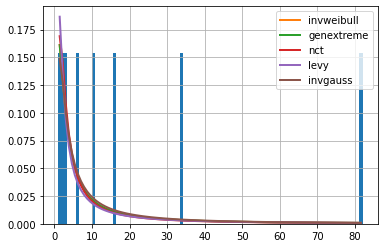

In [261]:
data_idx=8
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

INFO:root:Fitted anglit distribution with error=0.4166232946711013)
INFO:root:Fitted dweibull distribution with error=0.4121470874512798)
INFO:root:Fitted cosine distribution with error=0.4167151867648199)
INFO:root:Fitted cauchy distribution with error=0.41273506960228074)
INFO:root:Fitted expon distribution with error=0.4011645477079866)
INFO:root:Fitted dgamma distribution with error=0.41139231501951046)
INFO:root:Fitted bradford distribution with error=0.40776074389442474)
INFO:root:Fitted alpha distribution with error=0.41762837823054744)
INFO:root:Fitted arcsine distribution with error=0.3874360654224607)
INFO:root:Fitted gumbel_l distribution with error=0.41894207245790527)
INFO:root:Fitted argus distribution with error=0.4178809643134194)
INFO:root:Fitted beta distribution with error=0.3975774445920592)
INFO:root:Fitted gumbel_r distribution with error=0.4134332628122196)
INFO:root:Fitted chi2 distribution with error=0.405846777897037)
INFO:root:Fitted erlang distribution with 

Fitted cumulative degree distribution on LD1-layer of CM004_valid


,sumsquare_error,aic,bic,kl_div
exponweib,0.353124,1172.106998,-6.814115,inf
weibull_min,0.354314,1114.602073,-8.406732,inf
ncf,0.354419,1039.242437,-5.186375,inf
lognorm,0.356032,1300.831554,-8.382544,inf
genhyperbolic,0.356166,1037.752132,-5.161797,inf


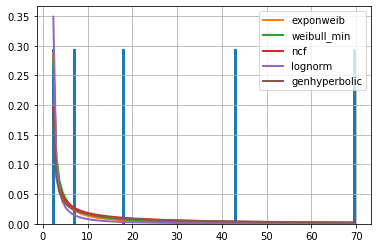

In [263]:
data_idx=9
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

INFO:root:Fitted anglit distribution with error=1236.2346578922175)
INFO:root:Fitted cosine distribution with error=1236.8049356302336)
INFO:root:Fitted expon distribution with error=1218.2032100037932)
INFO:root:Fitted cauchy distribution with error=1239.6052371484857)
INFO:root:Fitted alpha distribution with error=1236.2801617843572)
INFO:root:Fitted arcsine distribution with error=1145.8686036876434)
INFO:root:Fitted argus distribution with error=1232.2620392210301)
INFO:root:Fitted gumbel_l distribution with error=1236.247855018107)
INFO:root:Fitted bradford distribution with error=1223.9445448854922)
INFO:root:Fitted gamma distribution with error=1237.4416375058004)
INFO:root:Fitted gumbel_r distribution with error=1236.247855018107)
INFO:root:Fitted erlang distribution with error=1237.4416375058004)
INFO:root:Fitted foldnorm distribution with error=1230.3511411931895)
INFO:root:Fitted halfnorm distribution with error=1230.348656036183)
INFO:root:Fitted chi distribution with error

Fitted cumulative degree distribution on LD1-layer of CM005_valid


,sumsquare_error,aic,bic,kl_div
halfcauchy,688.190052,1136.928680,13.068130,inf
norminvgauss,909.589919,922.464049,15.012282,inf
halfgennorm,935.036579,383.310254,14.374318,inf
johnsonsb,938.075181,353.676305,15.073955,inf
mielke,941.960202,1082.609662,15.082220,inf


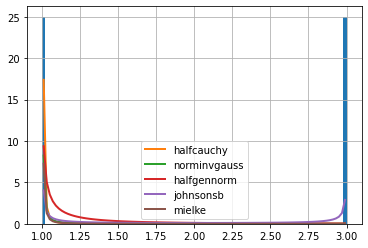

In [264]:
data_idx=10
degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,1]>0, 1], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)

f = Fitter(data=cs)  # 创建Fitter类
f.fit()  # 调用fit函数拟合分布
print(f'Fitted cumulative degree distribution on LD1-layer of {index_labels[data_idx]}')
f.summary()  # 输出拟合结果

# Plot of degree distribution

In [ ]:
degree_sequence = sorted(degrees[0][degrees[0][:,1]>0, 1], reverse=True)

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(20, 70))
axes = axes.flat
custom_lines = [Line2D([0], [0], color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3) for LD in [1,2,3,5,7]]

for ax_idx, data_idx in zip(range(0,12),gen_index(0,5)):
    for LD in [1,2,3,5,7]:
        # degree_sequence = sorted(degrees[data_idx][:, LD], reverse=True)  # degree sequence
        degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,LD]>0, LD], reverse=True)  # degree sequence
        if len(degree_sequence)>0:
            degreeCount = collections.Counter(degree_sequence)
            deg, cnt = zip(*degreeCount.items())
            cnt_frequency = list(map(lambda x: x/sum(cnt), cnt))
            cs = np.cumsum(cnt_frequency)
            axes[ax_idx].loglog(deg, cs, color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3)
    axes[ax_idx].set_ylabel('Cumulative degree frequency', fontsize=16)
    axes[ax_idx].set_xlabel(f'Degree', fontsize=16)
    axes[ax_idx].legend(handles=custom_lines, labels=[f'LD{x}' for x in [1,2,3,5,7]], loc='lower left', fontsize='large', title_fontsize='large')
    axes[ax_idx].set_title(f'Cumulative degree frequency plot of {index_labels[data_idx]}',fontsize=18)
    
# plt.savefig(f'plot/cumulative_degree_frequency_without_0.png', format='png', bbox_inches='tight')
plt.show()


KeyboardInterrupt



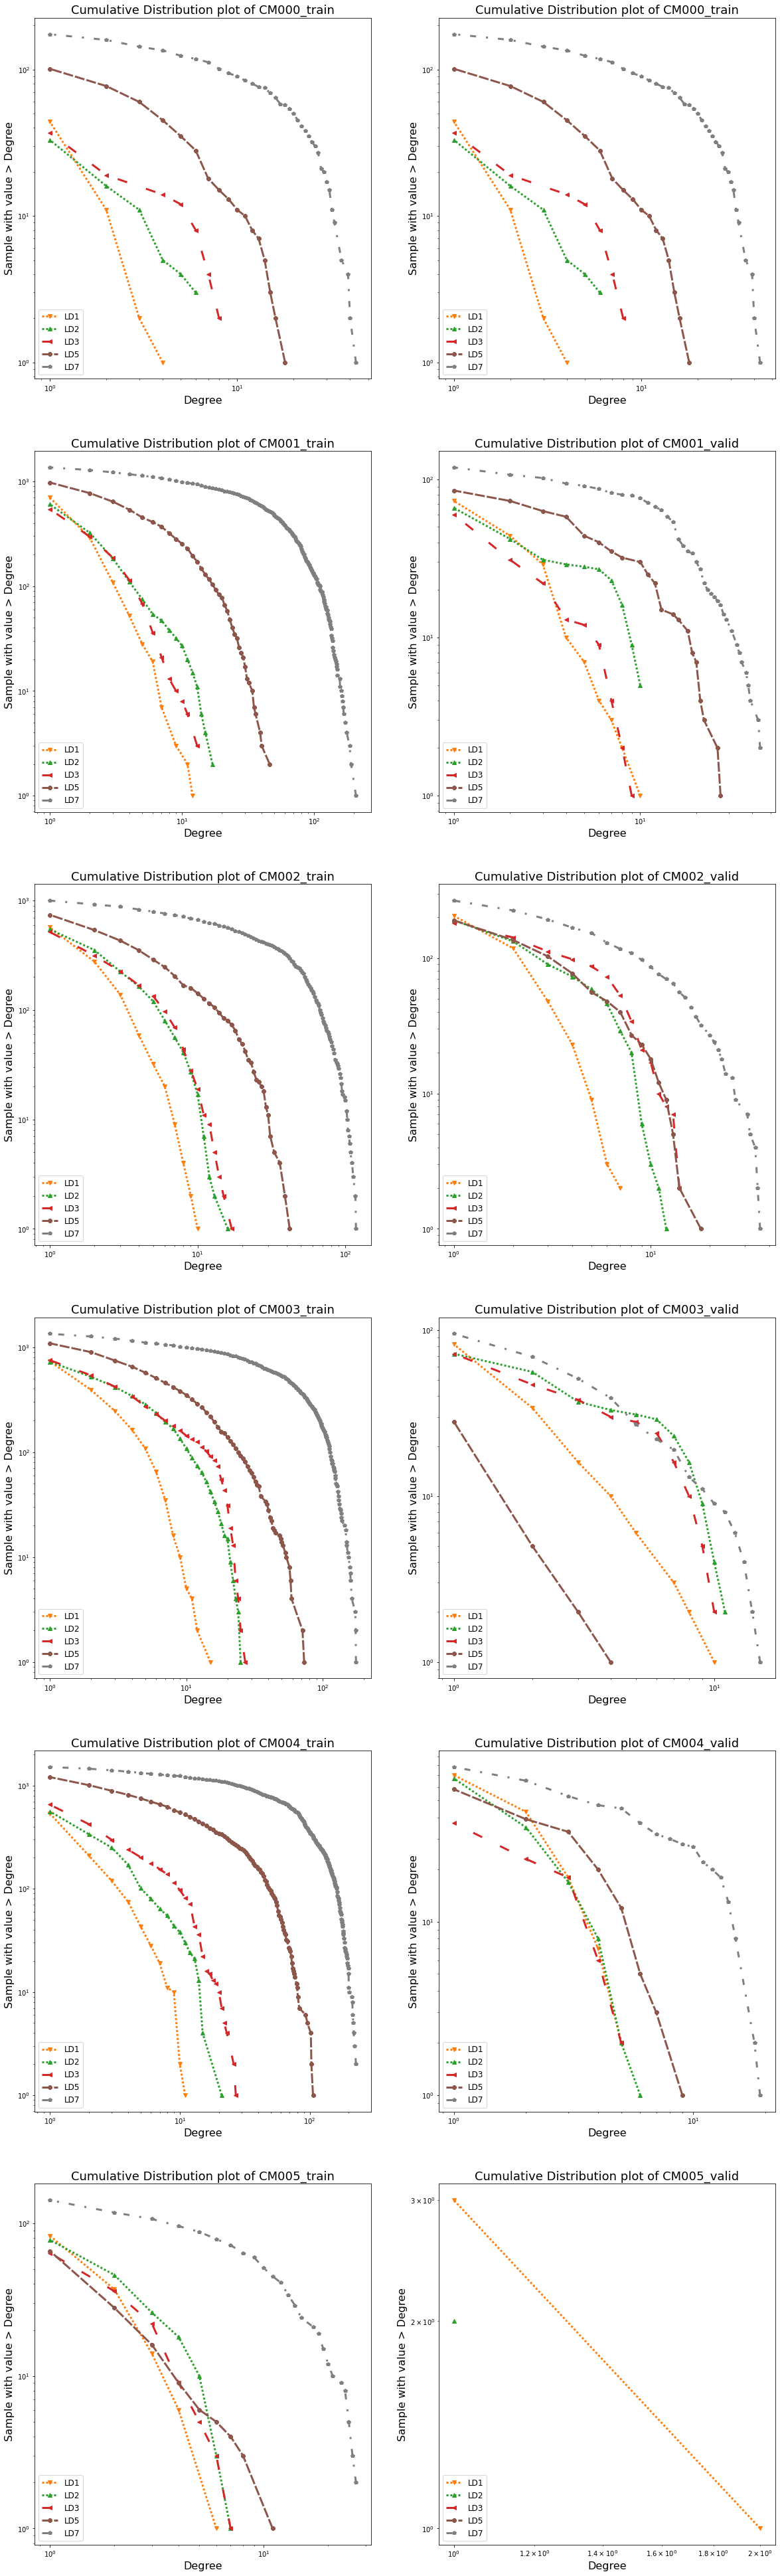

In [205]:
fig, axes = plt.subplots(6, 2, figsize=(20, 70))
axes = axes.flat
custom_lines = [Line2D([0], [0], color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3) for LD in [1,2,3,5,7]]

for ax_idx, data_idx in zip(range(0,12),gen_index(0,5)):
    for LD in [1,2,3,5,7]:
        # degree_sequence = sorted(degrees[data_idx][:, LD], reverse=True)  # degree sequence
        degree_sequence = sorted(degrees[data_idx][degrees[data_idx][:,LD]>0, LD], reverse=True)  # degree sequence
        if len(degree_sequence)>0:
            degreeCount = collections.Counter(degree_sequence)
            deg, cnt = zip(*degreeCount.items())
            cs = np.cumsum(cnt)
            axes[ax_idx].loglog(deg, cs, color=colors[LD], marker=Line2D.filled_markers[LD], ms=6, ls=linestyle_tuple[LD][1], lw=3)
    axes[ax_idx].set_ylabel('Sample with value > Degree', fontsize=16)
    axes[ax_idx].set_xlabel(f'Degree', fontsize=16)
    axes[ax_idx].legend(handles=custom_lines, labels=[f'LD{x}' for x in [1,2,3,5,7]], loc='lower left', fontsize='large', title_fontsize='large')
    axes[ax_idx].set_title(f'Cumulative Distribution plot of {index_labels[data_idx]}',fontsize=18)
    
plt.savefig(f'plot/cumulative_degree_distribution_without_0.png', format='png', bbox_inches='tight')
plt.show()

In [20]:
for u, v, weight in gs[0].edges.data("weight"):
    print(u, v, weight)
    break

ATEYNWNYGDWFDP ARGADY 11


In [21]:
subgraphs = []
for g_idx, g in enumerate(gs):
    edges = {i:[] for i in range(1,13)}
    for u,v,weight in g.edges.data("weight"):
        edges[weight].append((u,v))
    subgraph = []
    for i in range(1,13):
        subgraph.append(g.edge_subgraph(edges[i]))
    subgraphs.append(subgraph)

In [38]:
# 持久化network
# Note: networkx输出gml文件时，除过node id和edge id为int外，attribute均为str,所以需要指定stringizer=str
gml_path = Path('gml')
# if not gml_path.exists():
#     gml_path.mkdir(mode=511, parents=True)
for i in range(0, 11):
    if i<6:
        nx.write_gml(subgraphs[i][2], gml_path/f'CM00{i}_train_LD3.gml', stringizer=str)
        print(f'CM00{i}_train_LD3.gml is writed.')
    else:
        nx.write_gml(subgraphs[i][2], gml_path/f'CM00{i-5}_valid_LD3.gml', stringizer=str)
        print(f'CM00{i-5}_valid_LD3.gml is writed.')

CM000_train_LD3.gml is writed.
CM001_train_LD3.gml is writed.
CM002_train_LD3.gml is writed.
CM003_train_LD3.gml is writed.
CM004_train_LD3.gml is writed.
CM005_train_LD3.gml is writed.
CM001_valid_LD3.gml is writed.
CM002_valid_LD3.gml is writed.
CM003_valid_LD3.gml is writed.
CM004_valid_LD3.gml is writed.
CM005_valid_LD3.gml is writed.


In [34]:
subgraphs[0][0].edges.data()

EdgeDataView([('ARGADP', 'ARGADY', {'weight': 1}), ('ARGADP', 'ARGADH', {'weight': 1}), ('ARDYSNLFDY', 'ARDYSNYFDY', {'weight': 1}), ('ARDGAMVRGAFGGTYYYYYGMDV', 'ARDGTMVRGAFGGTYYYYYGMDV', {'weight': 1}), ('ARDIWDDNGDYNWHFDL', 'ARDIWDDYGDYNWHFDL', {'weight': 1}), ('ARHGRYNWNSYFDY', 'ARHQRYNWNSYFDY', {'weight': 1}), ('ARDGTTVRGAFGGTYYYYYGMDV', 'ARDGTMVRGAFGGTYYYYYGMDV', {'weight': 1}), ('ATGHFTFYYGSGSPGMDV', 'ATGHYTFYYGSGSPGMDV', {'weight': 1}), ('ARLYNWNFFDY', 'ARPYNWNFFDY', {'weight': 1}), ('AKDAHDYGDHYYYYGMDV', 'AKEAHDYGDHYYYYGMDV', {'weight': 1}), ('ARQYYNDSPLFDP', 'ARQYYGDSPLFDP', {'weight': 1}), ('ARGADH', 'ARGADY', {'weight': 1}), ('ARGHD', 'ARGHY', {'weight': 1}), ('AIDLTTVVTGY', 'ATDLTTVVTGY', {'weight': 1}), ('ATDLTTVLTGY', 'ATDLTTVVTGY', {'weight': 1}), ('ARAFNWNFFDY', 'ARPFNWNFFDY', {'weight': 1}), ('ARPYNWNFFDY', 'ARPFNWNFFDY', {'weight': 1}), ('ARGRY', 'ARGQY', {'weight': 1}), ('ARGRY', 'ARGHY', {'weight': 1}), ('ARGHY', 'ARGQY', {'weight': 1}), ('ARGHY', 'VRGHY', {'weight'

#### nx.draw(gs[-1])

# A. Network size of antibody repertoires

1. Nodes, Edges, Largest component, perc_giant_component
2. Public clones
3. Global properties: average_cluster_size, average_cluster_number, average_degree; Average degree, clustering coefficient, density, (degree) centralization
4. Local properties: authority, PageRank, eigenvector, closeness, betweenness

### 定义：
1. largest component: the largest cluster of connected CDR3 clones.
2. diameter (d): the maximum distance (shortest path between two nodes) between any pair of CDR3 sequences.
3. clustering coefficient (C): represents the probability that neighbors of a node are also connected, which translates in antibody repertoires as the probability that CDR3 clones similar to a specific CDR3 are also similar among one another.
4. density (D): the ratio of the number of edges (CDR3 similarities) and the number of all possible edges in the network
5. assortativity coefficient (r): indicates if nodes in a network connect to nodes with similar characteristics.
6. Coreness: a measure of the network’s cohesion and allows one to understand the global network structure and is useful in comparing complex networks by analyzing the subsets of CDR3-cores that form layers in the antibody repertoire.
7. k-core of a graph is the maximal subgraph in which each node has at least degree k.

# Generate a distributed graph

In [19]:
g_rdds = []
for cdr3s in cdr3_over:
    g_rdd = generate_spark_graph(cdr3s, sc, max_ld=MAX_LD).cache()
    g_rdds.append(g_rdd)

INFO:__main__:number of strings 213
INFO:__main__:number of strings 1460
INFO:__main__:number of strings 1119
INFO:__main__:number of strings 1467
INFO:__main__:number of strings 1618
INFO:__main__:number of strings 195
INFO:__main__:number of strings 140
INFO:__main__:number of strings 322
INFO:__main__:number of strings 147
INFO:__main__:number of strings 108
INFO:__main__:number of strings 5


In [21]:
g_rdds[0].vertices.show(5)

+---+----------------+
| id|          string|
+---+----------------+
|  0|  ATEYNWNYGDWFDP|
|  1|          ARGADY|
|  2|   TTGHGDYYYGMDV|
|  3|ARDHYSNYPYYYGMDV|
|  4|           ARDLY|
+---+----------------+
only showing top 5 rows



In [44]:
type(g_rdds[0])

graphframes.graphframe.GraphFrame

In [22]:
comp_rdds = [g_rdd.connectedComponents() for g_rdd in g_rdds]

In [47]:
type(comp_rdds[0])

pyspark.sql.dataframe.DataFrame

In [23]:
comp_rdds[0].count()

213

In [46]:
comp_rdds[9].orderBy('component', ascending=False).show(10)

+---+--------------------+---------+
| id|              string|component|
+---+--------------------+---------+
| 88|AKDEGTYYDLLAGYSRG...|       88|
| 90|AKDEGTYYDILAGYSRG...|       88|
|  1|   ARDRGHDYSNYLNWFDP|        0|
|  3|      TTDPYSSGWYWFDP|        0|
|  2|       ARHVPYSSGWFDY|        0|
|  7|       ARWYGSGWFIFDY|        0|
|  4|       TTESDYGDYIFDY|        0|
|  5|        VRLSSGWYPFDY|        0|
|  6|             ARGLLDY|        0|
|  8|             ATGVFDY|        0|
+---+--------------------+---------+
only showing top 10 rows



In [32]:
%time comp_rdd = g_rdd.connectedComponents()

CPU times: user 149 ms, sys: 105 ms, total: 254 ms
Wall time: 25.1 s


In [33]:
comp_rdd.count()

3775

In [34]:
comp_rdd.sort('id').show()

+---+--------------------+---------+
| id|              string|component|
+---+--------------------+---------+
|  0|      ARGSSWPYFFGMDV|        0|
|  1|      ARDGGITLVEGLDV|        0|
|  2|      ARDGGIIMVEGLDV|        0|
|  3|      AREMYSSSSGAFDI|        0|
|  4|ARDFPSGSYYVDYYYYGMDV|        4|
|  5|AREGDCSSTSCYYYYYY...|        0|
|  6|AREGDCTSTSCYYYYYY...|        0|
|  7|AREGDCSSTSCYYYYYY...|        0|
|  8|ARDQDDILTADYNGDHY...|        8|
|  9|ARDQDDILTDYYNGDYY...|        8|
| 10|ARDRDYILTDYYNGDYF...|        8|
| 11|  ARQEQWLGRPYNFYSLDV|        0|
| 12|  ARQEQWLGRPYNYFVMDV|        0|
| 13|  ARQEQWLGRPYYYYVMDV|        0|
| 14|  ARQEQWLGRPYYYYAMDV|        0|
| 15|  ARQEQWLGRPYNYYSMDV|        0|
| 16|  ARQEQWLGRPYHYYGMDV|        0|
| 17|  ARQEQWLGRPYNYYAMDV|        0|
| 18|  ARDGGTGTLYYYYYGMDV|        0|
| 19|  ARASITMVRGVMSYGMDV|        0|
+---+--------------------+---------+
only showing top 20 rows



In [35]:
gb = comp_rdd.groupBy('component')
gb.count().sort('count', ascending=False).show()

+---------+-----+
|component|count|
+---------+-----+
|        0| 3019|
|     1211|   50|
|     1054|   15|
|      160|   14|
|     1613|   13|
|     2375|   13|
|     2771|    9|
|      737|    9|
|     3339|    8|
|      486|    7|
|     2032|    7|
|     1935|    7|
|      329|    7|
|     1701|    7|
|      145|    6|
|     2895|    6|
|     3392|    6|
|      881|    6|
|     3767|    6|
|      713|    6|
+---------+-----+
only showing top 20 rows



In [131]:
g_rdd2.vertices.count()

1307

In [132]:
g_rdd2.vertices.count()

1307

In [133]:
comp_rdd2 = g_rdd2.connectedComponents()

In [134]:
gb2 = comp_rdd2.groupBy('component')
gb2.count().sort('count', ascending=False).show()

+---------+-----+
|component|count|
+---------+-----+
|        0| 1301|
|     1219|    2|
|       30|    2|
|      352|    2|
+---------+-----+

